# 파인튜닝
- 트랜스포머(transformer) 계열 언어 모델(Language Model)을 사용함.
- 프리트레인(pretrain)*을 마친 언어 모델 위에 작은 모듈을 조금 더 쌓아 태스크를 수행하는 구조
- 문서 분류, 개체명 인식 등 다운스트림 데이터로 프리트레인 마친 BERT와 그 위의 작은 모듈을 포함한 전체 모델을 업데이트하는 과정을 파인튜닝(fine-tuning)이라 한다.
- BERT의 출력 결과 가운데 어떤 걸 사용하느냐에 따라 두 가지 방식으로 나눠짐.

*프리트레인: 대규모 말뭉치를 학습시켜 임베딩을 미리 만들어 놓은것.

- BERT는 트랜스포머의 인코더 블록(레이어)을 여러 개 쌓은 구조.
- 그림에서 확인할 수 있다시피 이 블록(레이어)의 입력과 출력은 입력 단어에 해당하는 벡터들의 시퀀스.
- 두 개씩 쌍을 지어 서로의 관계를 모두 고려하는 방식으로 계산.
- 문장을 단어 토큰화한 뒤 앞뒤에 문장 시작과 끝을 알리는 스페셜 토큰 CLS와 SEP를 각각 추가한 뒤 BERT에 입력.
- BERT 모델의 마지막 블록(레이어)의 출력 가운데 CLS에 해당하는 벡터를 추출
- 트랜스포머 인코더 블록에서는 모든 단어가 서로 영향을 끼치기 때문에 마지막 블록 CLS 벡터는 문장 전체(이 영화 재미없네요)의 의미가 벡터 하나로 응집된 것
- 학습 과정에서는 BERT와 그 위에 쌓은 작은 모듈을 포함한 전체 모델의 출력이 정답 레이블과 최대한 같아지도록 모델 전체를 업데이트 이것이 파인튜닝(fine-tuning)이다.

## 단어 벡터 활용 : 개체명 인식 등
- 개체명 인식 같은 과제에서는 마지막 블록의 모든 단어 벡터를 활용
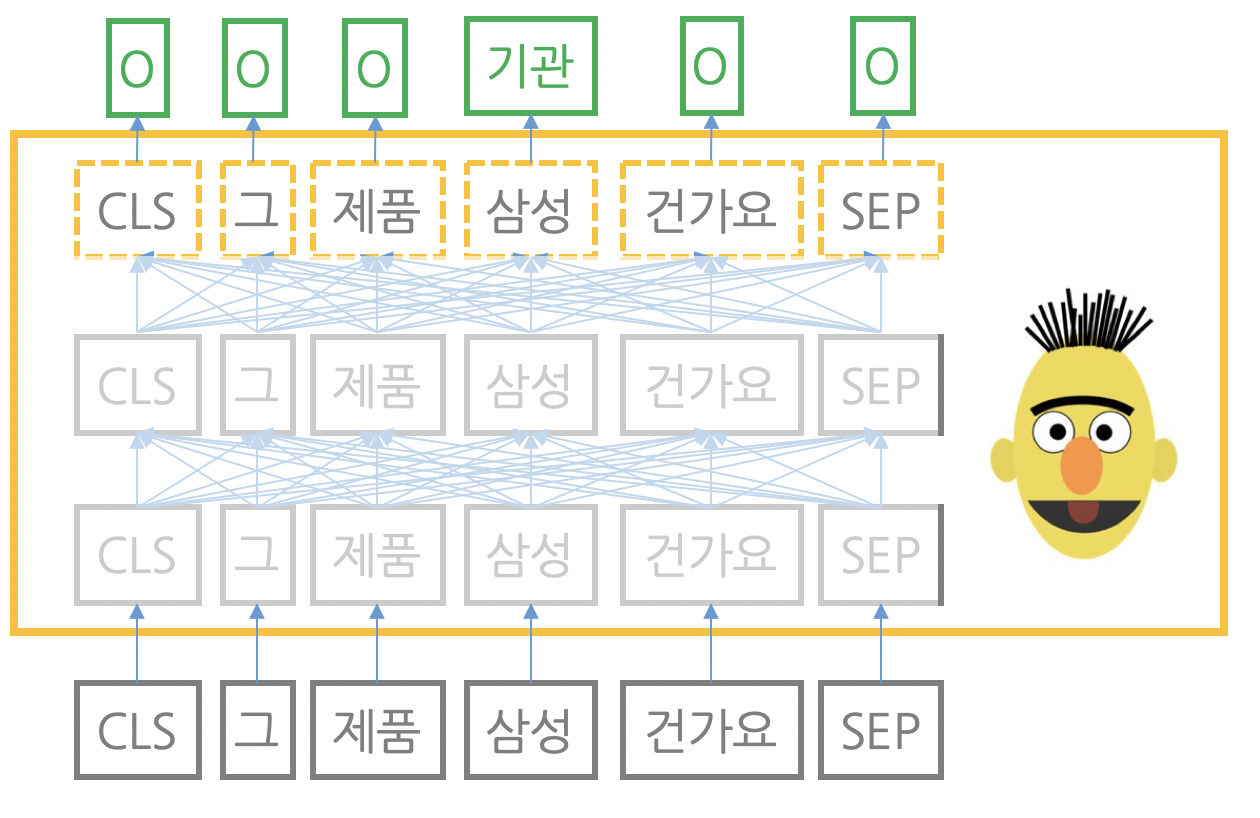

- 문서 분류 때와 동일한 방식으로 입력값을 만들고 BERT의 마지막 레이어까지 계산을 수행.
- BERT 모델의 마지막 블록(레이어)의 출력은 문장 내 모든 단어에 해당하는 벡터들의 시퀀스
- 그 출력이 각 개체명 범주(기관명, 인명, 지명 등)가 될 확률이 되도록 한다.
- 학습 과정에서는 BERT와 그 위에 쌓은 각각의 작은 모듈을 포함한 전체 모델의 출력이 정답 레이블과 최대한 같아지도록 모델 전체를 업데이트

# 튜토리얼
- 프리트레인을 마친 BERT 모델에 문장을 입력해서 이를 벡터로 변환하는 실습

## 실습환경 구성
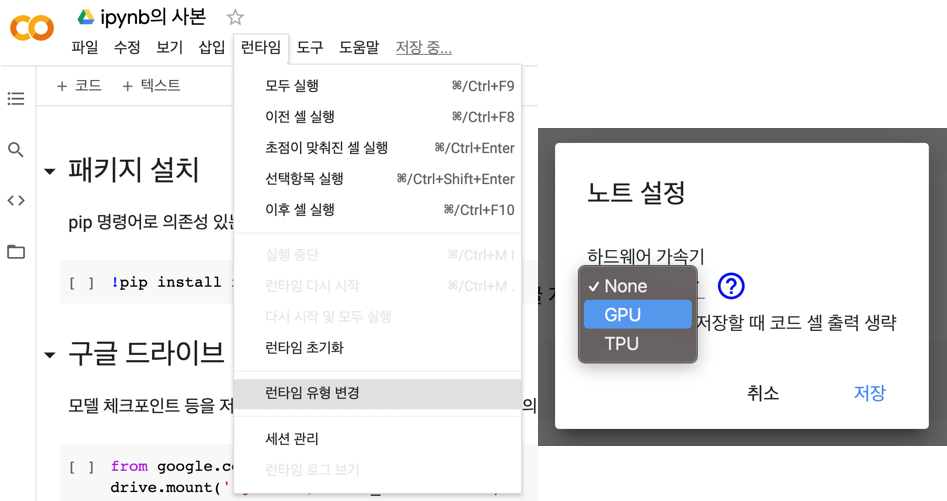

코랩 세션 유지
```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```

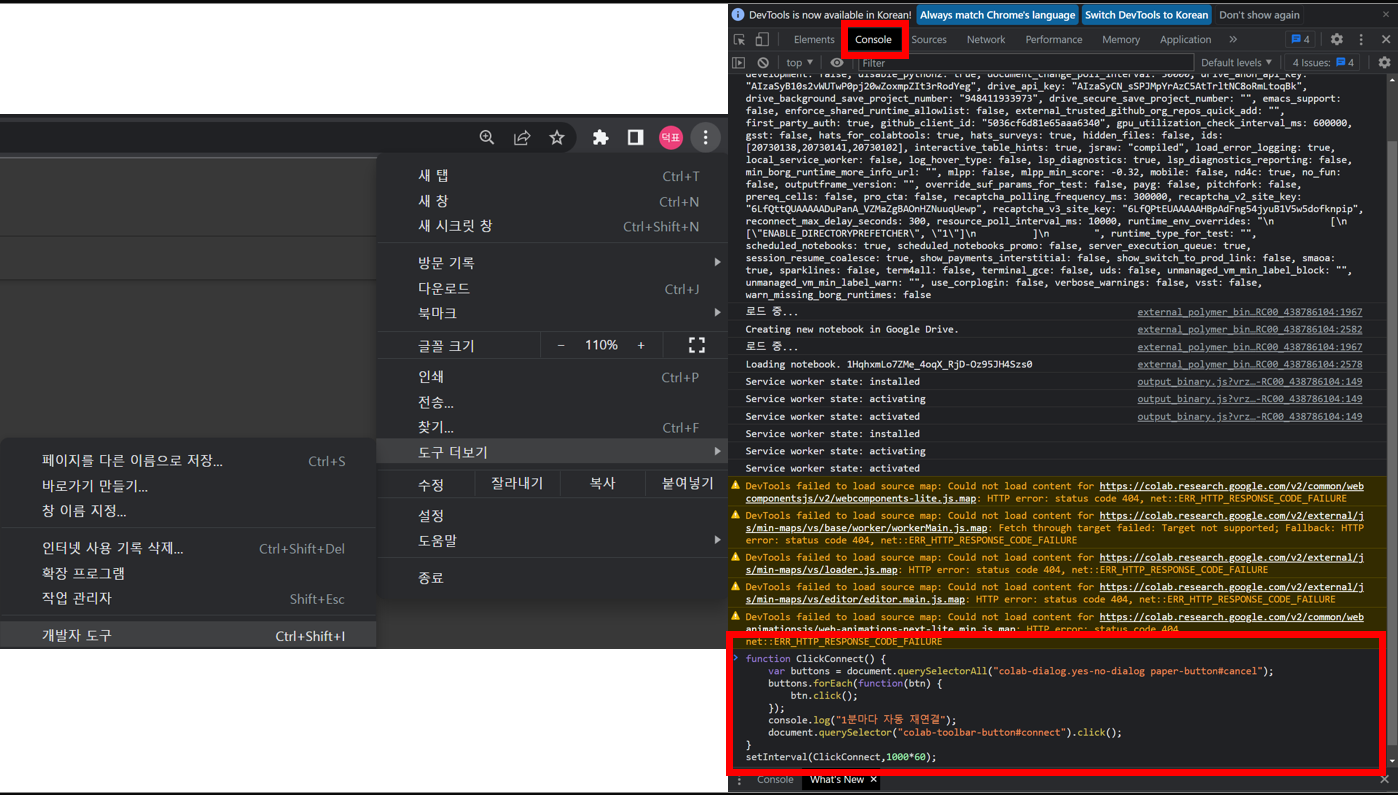

## 추가 라이브러리 설치

In [1]:
!pip install ratsnlp 

     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 806 kB 15.0 MB/s 
     |████████████████████████████████| 2.8 MB 76.0 MB/s 
     |████████████████████████████████| 57 kB 4.0 MB/s 
     |████████████████████████████████| 398 kB 92.3 MB/s 
     |████████████████████████████████| 829 kB 68.3 MB/s 
     |████████████████████████████████| 136 kB 69.9 MB/s 
     |████████████████████████████████| 636 kB 61.9 MB/s 
     |████████████████████████████████| 895 kB 67.8 MB/s 
     |████████████████████████████████| 3.3 MB 72.8 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 1.1 MB 57.2 MB/s 
     |████████████████████████████████| 96 kB 7.6 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 76.8 MB/s 
     |████████████████████████████████| 144 kB 64.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sh

## 토크나이저 초기화
- BERT 모델의 입력값을 만들려면 토크나이저부터 선언
- 이준범 님이 허깅페이스에 등록한 'kcbert-base '모델이 쓰는 토크나이저를 선언

In [2]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    "beomi/kcbert-base",
    do_lower_case=False,
)

Downloading:   0%|          | 0.00/250k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

## 모델 초기화
- 사용 대상 BERT 모델이 프리트레인할 때 썼던 토크나이저를 그대로 사용해야 벡터 변환에 문제가 없다.
- 모델과 토크나이저의 토큰화 방식이 다를 경우 모델이 엉뚱한 결과를 출력한다.
- 모델을 선언할 때 토크나이저 초기화와 동일한 모델 이름으로 적용.

In [3]:
from transformers import BertConfig, BertModel
pretrained_model_config = BertConfig.from_pretrained(
    "beomi/kcbert-base"
)
model = BertModel.from_pretrained(
    "beomi/kcbert-base",
    config=pretrained_model_config,
)

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- 블록(레이어) 수는 12개, 헤드의 수는 12개, 어휘 집합의 크기는 3만개 등 정보를 확인할수 있음.

In [ ]:
pretrained_model_config

BertConfig {
  "_name_or_path": "beomi/kcbert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 300,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30000
}

- 층 확인

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30000, 768, padding_idx=0)
    (position_embeddings): Embedding(300, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

## 입력값 만들기
- 두 개의 입력 문장 각각에 대해 워드피스 토큰화를 수행한 뒤 이를 토큰 인덱스로 변환한 결과가 input_ids.
- BERT 모델은 문장 시작에 CLS, 끝에 SEP라는 스페셜 토큰을 추가하기 때문에 문장 두 개 모두 앞뒤에 이들 토큰에 대응하는 인덱스 2, 3이 덧붙여져 있음.
- max_length=10: 토큰 최대 길이를 10으로 설정.
- padding="max_length": max_length 보다 토큰 길이가 이보다 짧으면 최대 길이에 맞게 패딩
- truncation=True: max_length 보다 토큰 길이가 이보다 크면 뒤에 단어 제거

In [4]:
sentences = ["안녕하세요", "하이!"]
features = tokenizer(
    sentences,
    max_length=10,
    padding="max_length",
    truncation=True,
)

- input_ids의 길이는 두 문장 모두 10
- attention_mask는 패딩이 아닌 토큰이 1, 패딩인 토큰이 0으로 실제 토큰이 자리하는지 아닌지를 정보를 나타낸다.
- token_type_ids는 세그먼트(segment) 정보로 파인튜닝을 실시할 때는 모두 0

In [ ]:
features

{'input_ids': [[2, 19017, 8482, 3, 0, 0, 0, 0, 0, 0], [2, 15830, 5, 3, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}


## BERT에 적용
- 딥러닝 프레임워크로 파이토치(PyTorch)를 시용
- 파이토치 모델의 입력값 자료형은 파이토치에서 제공하는 텐서(tensor)여야 한다.
- 파이썬 리스트(list) 형태의 features를 텐서로 변환

In [5]:
import torch

In [6]:
# 피처를 토치 텐서로 변환
features = {k: torch.tensor(v) for k, v in features.items()}
features

{'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[    2, 19017,  8482,     3,     0,     0,     0,     0,     0,     0],
         [    2, 15830,     5,     3,     0,     0,     0,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
outputs = model(**features)

- 단어 수준 임베딩 결과
- 단어 수준 임베딩 결과는 개체명 인식 과제 같이 단어별로 수행해야 하는 태스크에 활용

In [ ]:
outputs.last_hidden_state

tensor([[[-0.6969, -0.8248,  1.7512,  ..., -0.3732,  0.7399,  1.1907],
         [-1.4803, -0.4398,  0.9444,  ..., -0.7405, -0.0211,  1.3064],
         [-1.4300, -0.5033, -0.2069,  ...,  0.1285, -0.2611,  1.6057],
         ...,
         [-1.4406,  0.3431,  1.4043,  ..., -0.0565,  0.8450, -0.2170],
         [-1.3625, -0.2404,  1.1757,  ...,  0.8876, -0.1054,  0.0734],
         [-1.4244,  0.1518,  1.2920,  ...,  0.0245,  0.7572,  0.0080]],

        [[ 0.9371, -1.4749,  1.7351,  ..., -0.3426,  0.8050,  0.4031],
         [ 1.6095, -1.7269,  2.7936,  ...,  0.3100, -0.4787, -1.2491],
         [ 0.4861, -0.4569,  0.5712,  ..., -0.1769,  1.1253, -0.2756],
         ...,
         [ 1.2362, -0.6181,  2.0906,  ...,  1.3677,  0.8132, -0.2742],
         [ 0.5409, -0.9652,  1.6237,  ...,  1.2395,  0.9185,  0.1782],
         [ 1.9001, -0.5859,  3.0156,  ...,  1.4967,  0.1924, -0.4448]]],
       grad_fn=<NativeLayerNormBackward0>)

- torch.Size([2, 10, 768]): 문장 두 개에 속한 각각의 토큰(최대 길이 10)을 768차원짜리의 벡터로 변환했다는 의미

In [ ]:
outputs.last_hidden_state.shape

torch.Size([2, 10, 768])

- shape은 [2, 768], 문장 두 개가 각각 768차원짜리의 벡터로 변환됐다는 의미입니다. 
- 이들은 BERT의 마지막 레이어 CLS 벡터

In [ ]:
outputs.pooler_output

tensor([[-0.1594,  0.0547,  0.1101,  ...,  0.2684,  0.1596, -0.9828],
        [-0.9221,  0.2969, -0.0110,  ...,  0.4291,  0.0311, -0.9955]],
       grad_fn=<TanhBackward0>)

In [ ]:
outputs.pooler_output.shape

torch.Size([2, 768])

- 자연어를 벡터로 바꾼 결과를 임베딩(embedding) 또는 리프레젠테이션(representation)이라한다. 
- 안녕하세요, 하이!라는 문장은 ```outputs.last_hidden_state```을 통해 본 결과에선 단어 수준의 벡터 시퀀스로, ```outputs.pooler_output```를 통해 본 결과에선 문장 수준의 벡터로 변환